In [1]:
# Import necessary libraries  
import pandas as pd
import numpy as np

# Load the labels dataset from the .csv file
robberydf = pd.read_csv('/kaggle/input/dcsass-dataset/DCSASS Dataset/Labels/Robbery.csv')
burglarydf = pd.read_csv('/kaggle/input/dcsass-dataset/DCSASS Dataset/Labels/Burglary.csv')
shootingdf = pd.read_csv('/kaggle/input/dcsass-dataset/DCSASS Dataset/Labels/Shooting.csv')

In [2]:
# # Rename first column that contains the video paths
robberydf['video_path'] = robberydf['Robbery001_x264_0']
# Drop the unnecessary columns
robberydf = robberydf.drop(columns=['Robbery001_x264_0','Robbery'])
# Rename the columns for clarity
robberydf = robberydf.rename(columns={'0': 'label'})
robberydf['video_path'] = robberydf['video_path'].apply(lambda x: f"{x}.mp4")

# Rename first column that contains the video paths
burglarydf['video_path'] = burglarydf['Burglary001_x264_0']
# Drop the unnecessary columns
burglarydf = burglarydf.drop(columns=['Burglary001_x264_0','Burglary'])
# Rename the columns for clarity
burglarydf = burglarydf.rename(columns={'0': 'label'})
burglarydf['video_path'] = burglarydf['video_path'].apply(lambda x: f"{x}.mp4")

# Rename first column that contains the video paths
shootingdf['video_path'] = shootingdf['Shooting002_x264_0']
# Drop the unnecessary columns
shootingdf = shootingdf.drop(columns=['Shooting002_x264_0','Shooting'])
# Rename the columns for clarity
shootingdf = shootingdf.rename(columns={'0': 'label'})
shootingdf['video_path'] = shootingdf['video_path'].apply(lambda x: f"{x}.mp4")


In [ ]:
import tensorflow as tf
import cv2
import re
import numpy as np

import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

# Conditionally import tf_keras as keras for TensorFlow 3.x compatibility
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
    import tf_keras as keras
else:
    keras = tf.keras


def preprocess_image(image):
    # Resize the image to the expected input size of the MobileNet model (128x128)
    image = cv2.resize(image, (128, 128))
    # Normalize the pixel values to the range [0, 1]
    image = image / 255.0
    return image

class VideoDataGenerator(keras.utils.Sequence):
    def __init__(self, video_paths, labels, roots, batch_size=8, num_frames=16, target_size=(128, 128)):
        self.video_paths = video_paths
        self.labels = labels
        self.roots = roots
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.target_size = target_size
        print(video_paths)

    def __len__(self):
        return (len(self.video_paths) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        batch_paths = self.video_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_roots = self.roots[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = np.zeros((len(batch_paths), self.num_frames, *self.target_size, 3), dtype=np.float32)
        batch_y = np.zeros((len(batch_paths), 3), dtype=np.float32)

        for i, (video_path, root, label) in enumerate(zip(batch_paths, batch_roots, batch_labels)):
            frames = self._load_video_frames(root, video_path)
            batch_x[i] = frames
            batch_y[i] = label

        return batch_x, batch_y

    def _load_video_frames(self, root, video_path):
        full_path = re.sub(r'_\d+', '', root + '/' + video_path)
        cap = cv2.VideoCapture(full_path + '/' + video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        frame_indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=np.int32)
        frames = []

        for fi in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, fi)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, self.target_size)
            frame = frame / 255.0
            frames.append(frame)

        cap.release()

        # Pad if not enough frames
        while len(frames) < self.num_frames:
            frames.append(np.zeros((*self.target_size, 3)))

        return np.array(frames)

def prepare_dataset_generators(robbery_df, shooting_df, burglary_df, batch_size=32, test_size=0.4):
    label_map = {
        'robbery': {
            1: [1, 0, 0],  # Robbery is true
            0: [0, 0, 0]   # Robbery is false
        },
        'shooting':{
            1: [0, 1, 0],  # Robbery is true
            0: [0, 0, 0]   # Robbery is false
        },
        'burglary': { 
            1: [0, 0, 1],  # Robbery is true
            0: [0, 0, 0]   # Robbery is false
        }
    }
    
    
    robbery_df = robbery_df.copy()
    # robbery_df['one_hot_label'] = [label_map['robbery']] * len(robbery_df)
    robbery_df['one_hot_label'] = robbery_df['label'].map(label_map['robbery'])
    robbery_df['root'] = "/kaggle/input/dcsass-dataset/DCSASS Dataset/Robbery"

    shooting_df = shooting_df.copy()
    # shooting_df['one_hot_label'] = [label_map['shooting']] * len(shooting_df)
    shooting_df['one_hot_label'] = shooting_df['label'].map(label_map['shooting'])
    shooting_df['root'] = "/kaggle/input/dcsass-dataset/DCSASS Dataset/Shooting"

    burglary_df = burglary_df.copy()
    # burglary_df['one_hot_label'] = [label_map['burglary']] * len(burglary_df)
    burglary_df['one_hot_label'] = burglary_df['label'].map(label_map['burglary'])
    burglary_df['root'] = "/kaggle/input/dcsass-dataset/DCSASS Dataset/Burglary"

    full_df = pd.concat([robbery_df, shooting_df, burglary_df], ignore_index=True)

    train_df, test_df = train_test_split(
        full_df,
        test_size=test_size,
        random_state=42,
        stratify=full_df['root']
    )

    test_df, val_df = train_test_split(
        test_df,
        test_size=0.5,
        random_state=42,
        stratify=test_df['root']
    )

    train_gen = VideoDataGenerator(
        train_df['video_path'].values,
        train_df['one_hot_label'].values,
        train_df['root'].values,
        batch_size=batch_size
    )

    test_gen = VideoDataGenerator(
        test_df['video_path'].values,
        test_df['one_hot_label'].values,
        test_df['root'].values,
        batch_size=batch_size
    )

    
    val_gen = VideoDataGenerator(
        val_df['video_path'].values,
        val_df['one_hot_label'].values,
        val_df['root'].values,
        batch_size=batch_size
    )

    return train_gen, None, None

In [ ]:
class BayesianCrimeDetector:
    def __init__(self, learning_rate=0.0001):
        self.model_url = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2"
        self.learning_rate = learning_rate
    
    def train_model(self, train_gen, test_gen, epochs=15):
        
        mobilenet = keras.applications.MobileNetV2(
            include_top=False,
            input_shape=(128, 128, 3),
            weights='imagenet'
        )

        model = keras.Sequential([
            keras.layers.TimeDistributed(mobilenet, input_shape=(16, 128, 128, 3)),
            keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False),
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dense(3, activation='softmax')
        ])
        
        optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
        # Callbacks
        lr_scheduler = keras.callbacks.LearningRateScheduler(
            lambda epoch, lr: lr * 0.5 if epoch % 3 == 0 and epoch > 0 else lr
        )
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )
    
        history = model.fit(
            train_gen,
            validation_data=test_gen,
            epochs=epochs,
            callbacks=[lr_scheduler, early_stopping]
        )
    
        return history, model

In [36]:
crime_types = ["robbery", "shooting", "burglary"]
print("Preparing dataset generators...")
train_gen, test_gen, val_gen = prepare_dataset_generators(
    robberydf, shootingdf, burglarydf, batch_size=8
)

Preparing dataset generators...
['Robbery013_x264_6.mp4' 'Burglary055_x264_15.mp4'
 'Robbery120_x264_28.mp4' ... 'Robbery063_x264_12.mp4'
 'Shooting010_x264_19.mp4' 'Robbery048_x264_29.mp4']


In [35]:
x_batch, y_batch = train_gen[0]
print("x_batch shape:", x_batch.shape)
print("y_batch shape:", y_batch.shape)
print("y_batch dtype:", y_batch.dtype)

x_batch shape: (8, 16, 128, 128, 3)
y_batch shape: (8, 3)
y_batch dtype: float32


In [24]:
print("Creating and training the model...")
detector = BayesianCrimeDetector(learning_rate=0.0001)
history, model = detector.train_model(train_gen, val_gen, epochs=15)

Creating and training the model...
9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/15


I0000 00:00:1745431141.620099     127 service.cc:148] XLA service 0x7a3e1a47c420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745431141.620590     127 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745431141.620614     127 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745431141.792152     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 [==============================] - 628s 1s/step - loss: 0.3822 - accuracy: 0.7856 - val_loss: 0.4169 - val_accuracy: 0.8540 - lr: 1.0000e-04
Epoch 2/15
439/439 [==============================] - 565s 1s/step - loss: 0.2463 - accuracy: 0.8904 - val_loss: 0.3274 - val_accuracy: 0.8847 - lr: 1.0000e-04
Epoch 3/15
439/439 [==============================] - 572s 1s/step - loss: 0.2111 - accuracy: 0.9077 - val_loss: 0.2907 - val_accuracy: 0.8728 - lr: 1.0000e-04
Epoch 4/15
439/439 [==============================] - 562s 1s/step - loss: 0.1770 - accuracy: 0.9226 - val_loss: 0.1911 - val_accuracy: 0.9018 - lr: 5.0000e-05
Epoch 5/15
439/439 [==============================] - 559s 1s/step - loss: 0.1452 - accuracy: 0.9371 - val_loss: 0.1795 - val_accuracy: 0.9061 - lr: 5.0000e-05
Epoch 6/15
439/439 [==============================] - 563s 1s/step - loss: 0.1270 - accuracy: 0.9468 - val_loss: 0.1522 - val_accuracy: 0.9112 - lr: 5.0000e-05
Epoch 7/15
439/439 [==============================]

*--end--*

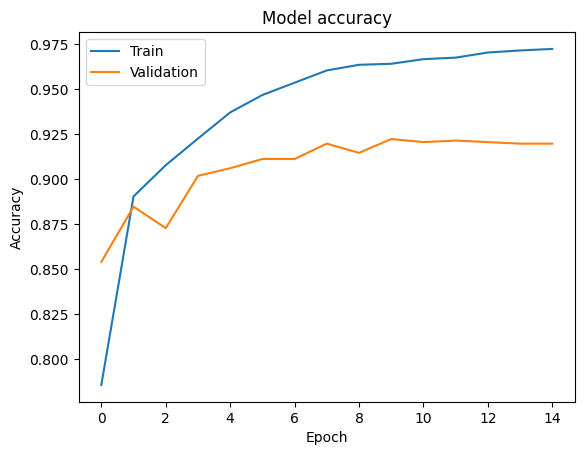

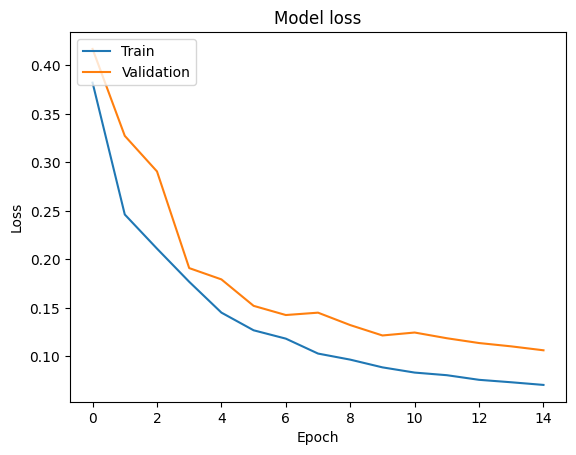

In [28]:
import matplotlib.pyplot as plt

# Enable eager execution
tf.config.run_functions_eagerly(True)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
# test_images, test_labels = preprocess_data(test_df)
predictions = model.predict(test_gen, verbose=0)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [27]:
model.save("my_model_final.h5")

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
